In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import numpy as np

import skimage
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn import cluster

import matplotlib.pyplot as plt

import os

%load_ext tensorboard
os.environ['TENSORBOARD_BINARY'] = '/Users/preetam/opt/anaconda3/envs/ml/bin/tensorboard'

In [3]:
train_set_images = './pipeline_outputs/data/train/'

In [4]:
img_file_paths = [f for f in os.listdir(train_set_images) if os.path.isfile(os.path.join(train_set_images, f))]
img_file_paths = [train_set_images + f for f in img_file_paths]
img_file_paths.sort()

In [5]:
NUM_IMAGES = len(img_file_paths)
IMG_WIDTH = 256
IMG_HEIGHT = 256

X_train = np.zeros( (NUM_IMAGES, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32 )
y_train = np.zeros( (NUM_IMAGES, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32 )

for img, i in zip(img_file_paths, range(NUM_IMAGES)):
    img_curr = imread(img)
    img_curr = resize(img_curr, (IMG_WIDTH, IMG_HEIGHT, 1), mode="constant", preserve_range=True)
    X_train[i] = img_curr
    
    
    
    x_ray = (np.int64(imread(img))).reshape((-1,1))
    k_m = cluster.KMeans(n_clusters=5, n_init=10)
    k_m.fit(x_ray)
    
    values, labels = np.int64(k_m.cluster_centers_.squeeze()), np.int64(k_m.labels_)
    img_segm = np.choose(labels, values)
    img_segm.shape = (256, 256, 1)
    
    pix_val = 0.0
    for value in (np.unique(img_segm)):
        img_segm = np.where(img_segm == value, pix_val, img_segm)
        pix_val += 0.25
        
    img_segm = np.where(img_segm > 0.5, 1, img_segm)
    img_segm = np.where(img_segm <= 0.5, 0, img_segm)
    img_segm = np.uint8(img_segm)
    y_train[i] = img_segm

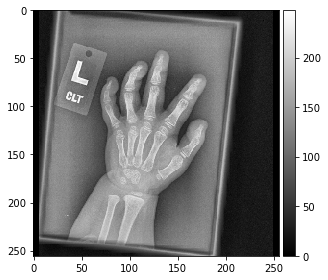

In [103]:
imshow(X_train[19], cmap=plt.cm.gray)

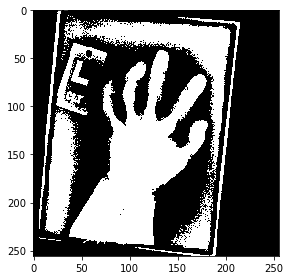

In [25]:
imshow(y_train[19], cmap=plt.cm.gray)

In [10]:
inputs = keras.layers.Input( (256, 256, 1) )
s = keras.layers.Lambda(lambda x: x / 255.)(inputs)

# contracting path
c1 = keras.layers.Conv2D(64, (5,5), activation="relu", kernel_initializer="he_normal", padding="same")(s)
c1 = keras.layers.Dropout(0.2)(c1)
c1 = keras.layers.Conv2D(64, (5,5), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = keras.layers.MaxPooling2D( (2,2) )(c1)

c2 = keras.layers.Conv2D(96, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = keras.layers.Dropout(0.2)(c2)
c2 = keras.layers.Conv2D(96, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = keras.layers.MaxPooling2D( (2,2) )(c2)

c3 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = keras.layers.Dropout(0.2)(c3)
c3 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = keras.layers.MaxPooling2D( (2,2) )(c3)

c4 = keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = keras.layers.Dropout(0.2)(c4)
c4 = keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = keras.layers.MaxPooling2D( (2,2) )(c4)

c5 = keras.layers.Conv2D(512, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = keras.layers.Dropout(0.2)(c5)
c5 = keras.layers.Conv2D(512, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

# expansive path
u6 = keras.layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = keras.layers.Dropout(0.2)(c6)
c6 = keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

u7 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
c7 = keras.layers.Dropout(0.2)(c7)
c7 = keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

u8 = keras.layers.Conv2DTranspose(96, (2,2), strides=(2,2), padding="same")(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(96, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8 = keras.layers.Dropout(0.1)(c8)
c8 = keras.layers.Conv2D(96, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

u9 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(64, (5,5), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9 = keras.layers.Dropout(0.1)(c9)
c9 = keras.layers.Conv2D(64, (5,5), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

outputs = keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

In [11]:
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
#     y_true_f = tf.cast(y_true_f, dtype=tf.float32)
#     y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)
#     return (1 - dice)
    return dice

In [12]:
from keras.backend import epsilon
EPSILON = epsilon()
def bce(y_true, y_pred):
    y_pred_f = tf.cast(y_pred, tf.int32)
    y_true_f = tf.cast(y_true, tf.float32)
    
    y_pred_f  = tf.math.greater(y_pred_f, tf.constant([0.5]))
    y_pred_f = tf.cast( y_pred_f , tf.float32)
    
#     y_pred = y_pred.numpy()
#     y_pred = np.where(y_pred >= 0.5, 1)
#     y_pred = np.where(y_pred < 0.5, 0)
#     y_pred = tf.to_int32(y_pred > 0.5)
    
#     y_pred = tf.cast(y_pred > 0.5, tf.int32)
#     y_pred_f = tf.math.greater(y_pred, tf.constant([0.5]))
#     y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    
    epsilon_ = tf.constant(EPSILON, y_pred_f.dtype.base_dtype)
    y_pred_f = tf.clip_by_value(y_pred_f, epsilon_, 1. - epsilon_)
#     y_pred_f = tf.math.greater(y_pred_f, tf.constant([0.5]))
#     y_pred_f = tf.cast(y_pred_f, tf.float32)
    
    bce = y_true_f * tf.math.log(y_pred_f + epsilon_)
    bce += (1 - y_true_f) * tf.math.log(1 - y_pred_f + epsilon_)
    
    return -bce

Using TensorFlow backend.


In [13]:
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1664        lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [14]:
checkpointer = keras.callbacks.ModelCheckpoint('DDUNET_train_custom_loss_2.h5', verbose=1, save_best_only=True)

In [15]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    keras.callbacks.TensorBoard(log_dir='logs_ddunet_custom_loss_2'),
    checkpointer
]

In [16]:
model.fit(X_train[:100], y_train[:100], validation_split=0.3, batch_size=10, epochs=25, callbacks=callbacks)

Train on 70 samples, validate on 30 samples
Epoch 1/25
60/70 [========================>.....] - ETA: 1:39 - loss: 1.3144 - accuracy: 0.4826
Epoch 00001: val_loss improved from inf to 0.69203, saving model to DDUNET_train_custom_loss_2.h5
70/70 [==============================] - 830s 12s/sample - loss: 1.2257 - accuracy: 0.4849 - val_loss: 0.6920 - val_accuracy: 0.4968
Epoch 2/25
60/70 [========================>.....] - ETA: 2:35 - loss: 0.6892 - accuracy: 0.6255
Epoch 00002: val_loss improved from 0.69203 to 0.68143, saving model to DDUNET_train_custom_loss_2.h5
70/70 [==============================] - 1173s 17s/sample - loss: 0.6885 - accuracy: 0.6361 - val_loss: 0.6814 - val_accuracy: 0.7012
Epoch 3/25
60/70 [========================>.....] - ETA: 2:24 - loss: 0.6794 - accuracy: 0.6828
Epoch 00003: val_loss improved from 0.68143 to 0.66201, saving model to DDUNET_train_custom_loss_2.h5
70/70 [==============================] - 1112s 16s/sample - loss: 0.6777 - accuracy: 0.6927 - val_l

In [28]:
from tensorflow.keras.models import load_model

MODEL_PATH = "FINAL_UNET_MODEL.h5"
model = load_model(MODEL_PATH)

In [49]:
results = model.predict(X_train[:16], verbose=1)

16/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 51s 3s/sample


/Users/preetam/opt/anaconda3/envs/ml/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


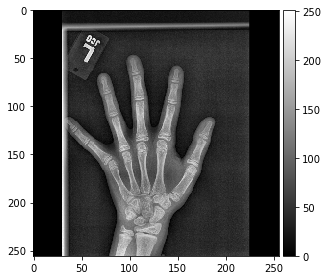

In [102]:
imshow(X_train[10], cmap=plt.cm.gray)

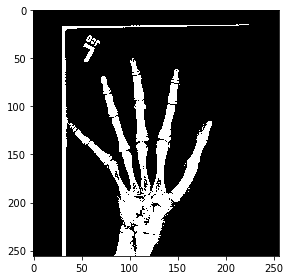

In [101]:
imshow(y_train[10], cmap=plt.cm.gray)

/Users/preetam/opt/anaconda3/envs/ml/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


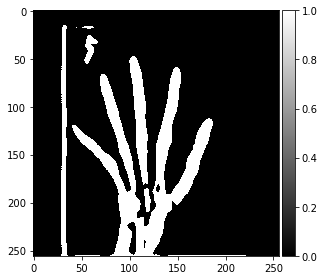

In [19]:
test_img = results[10]
test_img = np.where(test_img >= np.mean(test_img), 1, 0)

imshow(test_img, cmap=plt.cm.gray)

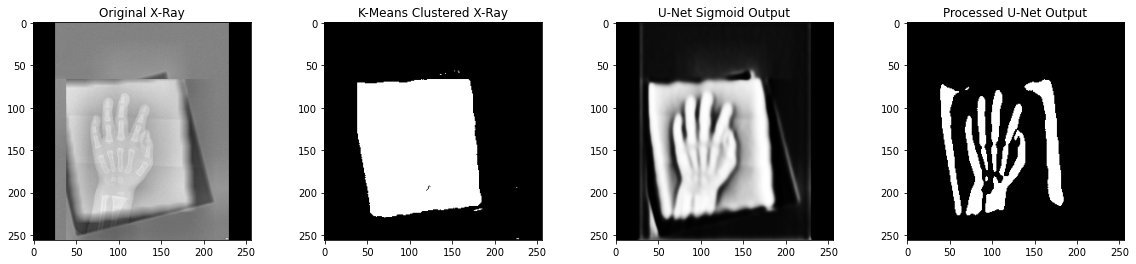

In [64]:
# SAMPLES 8 AND 7!!!!!!!

SAMPLE_NUMBER = 1

i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=False)
i.set_figwidth(20)

im1.title.set_text("Original X-Ray")
im1.imshow(X_train[SAMPLE_NUMBER], cmap=plt.cm.gray)

im2.title.set_text("K-Means Clustered X-Ray")
im2.imshow(y_train[SAMPLE_NUMBER], cmap=plt.cm.gray)

im3.title.set_text("U-Net Sigmoid Output")
im3.imshow(results[SAMPLE_NUMBER], cmap=plt.cm.gray)

test_img = results[SAMPLE_NUMBER]
thresh = np.mean(test_img) + 0.6
test_img = np.where(test_img >= thresh, 1, test_img)
test_img = np.where(test_img < thresh, 0, test_img)
im4.title.set_text("Processed U-Net Output")
im4.imshow(test_img, cmap=plt.cm.gray)

In [66]:
test_set_images = './pipeline_outputs/data/test/'

In [67]:
test_file_paths = [f for f in os.listdir(test_set_images) if os.path.isfile(os.path.join(test_set_images, f))]
test_file_paths = [test_set_images + f for f in test_file_paths]
test_file_paths.sort()

In [68]:
NUM_IMAGES = len(test_file_paths)
IMG_WIDTH = 256
IMG_HEIGHT = 256

X_test = np.zeros( (NUM_IMAGES, IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.float32 )

for img, i in zip(test_file_paths, range(NUM_IMAGES)):
    img_curr = imread(img)
    img_curr = resize(img_curr, (IMG_WIDTH, IMG_HEIGHT, 1), mode="constant", preserve_range=True)
    X_test[i] = img_curr

In [ ]:
test_results = model.predict(X_test, verbose=1)

In [ ]:
SAMPLE_NUMBER = 20

i, (im1, im2, im3) = plt.subplots(1, 3, sharey=False)
i.set_figwidth(20)

im1.title.set_text("Original X-Ray")
im1.imshow(X_test[SAMPLE_NUMBER], cmap=plt.cm.gray)

im2.title.set_text("U-Net Sigmoid Output")
im2.imshow(test_results[SAMPLE_NUMBER], cmap=plt.cm.gray)

test_img = test_results[SAMPLE_NUMBER]
thresh = np.mean(test_img)
test_img = np.where(test_img >= thresh, 1, test_img)
test_img = np.where(test_img < thresh, 0, test_img)
im3.title.set_text("Processed U-Net Output")
im3.imshow(test_img, cmap=plt.cm.gray)

In [26]:
%tensorboard --logdir logs_ddunet_custom_loss_2

In [44]:
model.save("FINAL_UNET_MODEL.h5")